# Part 1: Exploratory data analysis

In [ ]:
!pip install findspark
!pip install plotly
!pip install chart-studio

In [ ]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-2.4.6/spark-2.4.6-bin-hadoop2.7.tgz
!tar xf spark-2.4.6-bin-hadoop2.7.tgz
!pip install -q findspark

In [ ]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-2.4.6-bin-hadoop2.7"

In [ ]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [ ]:
import findspark
findspark.init()

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql import functions as F
from pyspark.sql.functions import isnan, when, count, col, year, quarter, lit, to_date, to_timestamp, concat, avg
from pyspark.sql.types import DateType, TimestampType
from pyspark import SparkContext
from pyspark import SparkConf
from pyspark.ml.feature import Imputer
from pyspark.sql import DataFrameStatFunctions as statFunc
from pyspark.ml.feature import StringIndexer
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import IndexToString
from pyspark.mllib.tree import RandomForest, RandomForestModel
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import NaiveBayes
from pyspark.ml.classification import LinearSVC
from pyspark.ml.evaluation import BinaryClassificationEvaluator
from pyspark.mllib.evaluation import BinaryClassificationMetrics
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.feature import PCA


from pyspark.ml.classification import LogisticRegression
from pyspark.mllib.classification import LogisticRegressionWithLBFGS

from pyspark.ml import Pipeline
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

from pyspark.mllib.classification import SVMWithSGD, SVMModel
from pyspark.mllib.regression import LabeledPoint

from pyspark.ml.tuning import CrossValidator, ParamGridBuilder

from sklearn.metrics import roc_curve, auc


#%matplotlib inline

import datetime
import numpy as np
import pandas as pd
from pandas import DataFrame as df
%matplotlib inline
import matplotlib
# Force matplotlib to not use any Xwindows backend.
# matplotlib.use('Agg')
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(color_codes=True)
from scipy import stats

import chart_studio.plotly as py

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode,iplot
init_notebook_mode(connected=True)

import os
memory = '4g'
pyspark_submit_args = ' --driver-memory ' + memory + ' pyspark-shell'
os.environ["PYSPARK_SUBMIT_ARGS"] = pyspark_submit_args

#sc = SparkContext()  
SparkContext.setSystemProperty('spark.executor.memory', '4g')
SparkContext.setSystemProperty('spark.driver.memory', '4g')

spark_conf = SparkConf().setAll(pairs = [('spark.executor.memory', '4g'), ('spark.executor.cores', '3'), ('spark.cores.max', '3'), ('spark.driver.memory','4g')])

spark = SparkSession.builder.master("local[*]").config(conf = spark_conf).appName("Lending-Club Loan Analysis using Pyspark").getOrCreate()
sqlContext = SQLContext(spark)

spark.sparkContext.setLogLevel('ERROR')

import warnings
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


### Load Data to Spark DataFrame

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
loanDF = spark.read.csv("/content/drive/My Drive/train_data.csv", header=True, mode="DROPMALFORMED")
#loanDF = spark.read.csv("loan.csv", header=True, mode="DROPMALFORMED", inferSchema =True)

#loanDFRows = loanDF.count()

loanDF.printSchema()

# Loading it as pandasDF also, only for the comparison/testing.
loanDF_Pandas = pd.read_csv("/content/drive/My Drive/train_data.csv", low_memory=False)

root
 |-- id: string (nullable = true)
 |-- member_id: string (nullable = true)
 |-- loan_amnt: string (nullable = true)
 |-- funded_amnt: string (nullable = true)
 |-- funded_amnt_inv: string (nullable = true)
 |-- term: string (nullable = true)
 |-- int_rate: string (nullable = true)
 |-- installment: string (nullable = true)
 |-- grade: string (nullable = true)
 |-- sub_grade: string (nullable = true)
 |-- emp_title: string (nullable = true)
 |-- emp_length: string (nullable = true)
 |-- home_ownership: string (nullable = true)
 |-- annual_inc: string (nullable = true)
 |-- verification_status: string (nullable = true)
 |-- issue_d: string (nullable = true)
 |-- loan_status: string (nullable = true)
 |-- pymnt_plan: string (nullable = true)
 |-- url: string (nullable = true)
 |-- desc: string (nullable = true)
 |-- purpose: string (nullable = true)
 |-- title: string (nullable = true)
 |-- zip_code: string (nullable = true)
 |-- addr_state: string (nullable = true)
 |-- dti: string 

In [ ]:
 print((loanDF.count(), len(loanDF.columns)))

(1827125, 145)


#### 1. Analyzing Loan amount and Interest rates

- Frequency distribution of loan amount with gamma distribution. 
- Five number summary distribution of loan amount.
- Frequency distribution of interest rates with gamma distribution. 
- Five number summary distribution of interest rates.

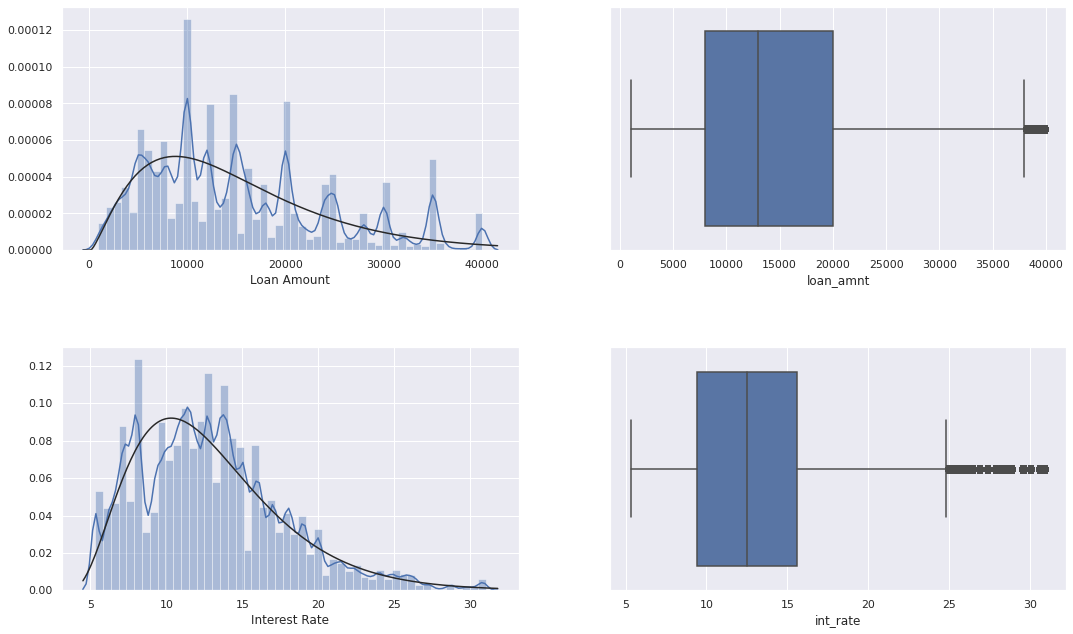

In [ ]:
loanDF = loanDF.withColumn("loan_amnt",loanDF["loan_amnt"].cast('float'))
loanDF = loanDF.withColumn("int_rate",loanDF["int_rate"].cast('float'))

tmp = loanDF.select("loan_amnt", "int_rate").toPandas()
#loanDF.printSchema()

fig, ax =plt.subplots(2,2, figsize=(18,12))
plt.subplots_adjust(hspace = 0.4, top = 0.8)

# Loan amount distribution plots
sns.distplot(tmp.loan_amnt, fit=stats.gamma, axlabel="Loan Amount", label="Loan Amount Frequency distribution", ax=ax[0][0])
sns.boxplot(x=tmp.loan_amnt, ax=ax[0][1])

# Interest rates distribution plots
sns.distplot(tmp.int_rate, fit=stats.gamma, axlabel="Interest Rate", label="Interest Frequency distribution", ax=ax[1][0])
sns.boxplot(x=tmp.int_rate, ax=ax[1][1])

fig.show()

fig.savefig("/content/drive/My Drive/LoanDistribution.pdf")

### Loan Counts group by loan_status

In [ ]:
#loanDF.registerTempTable("loanDFTable")

loanDF.groupBy('loan_status').count().sort("count", ascending=False).show()
#print(loanDF.loan_status.value_counts())

#print((loanDF[loanDF.loan_status.isin(["Default"])]).verification_status.value_counts())

#loanDF.loan_status.describe()

+-----------+------+
|loan_status| count|
+-----------+------+
| Fully Paid|865468|
|    Current|828131|
|Charged Off|133526|
+-----------+------+



### Default Loan Count group by varification_status

In [ ]:
#DataFrame newdf = df.select(df.col("*")).filter("somecol <= 10")

loanDF.filter("loan_status == 'Charged Off'").groupBy('verification_status').count().show()

+-------------------+-----+
|verification_status|count|
+-------------------+-----+
|           Verified|49306|
|    Source Verified|55497|
|       Not Verified|28723|
+-------------------+-----+



### 2. Analyzing Loans over loan status.

- Number of loans over for each loan status
- Distribution of total accounts for each status
- Distribution of loan amount with the probability density for each loan value over loan status

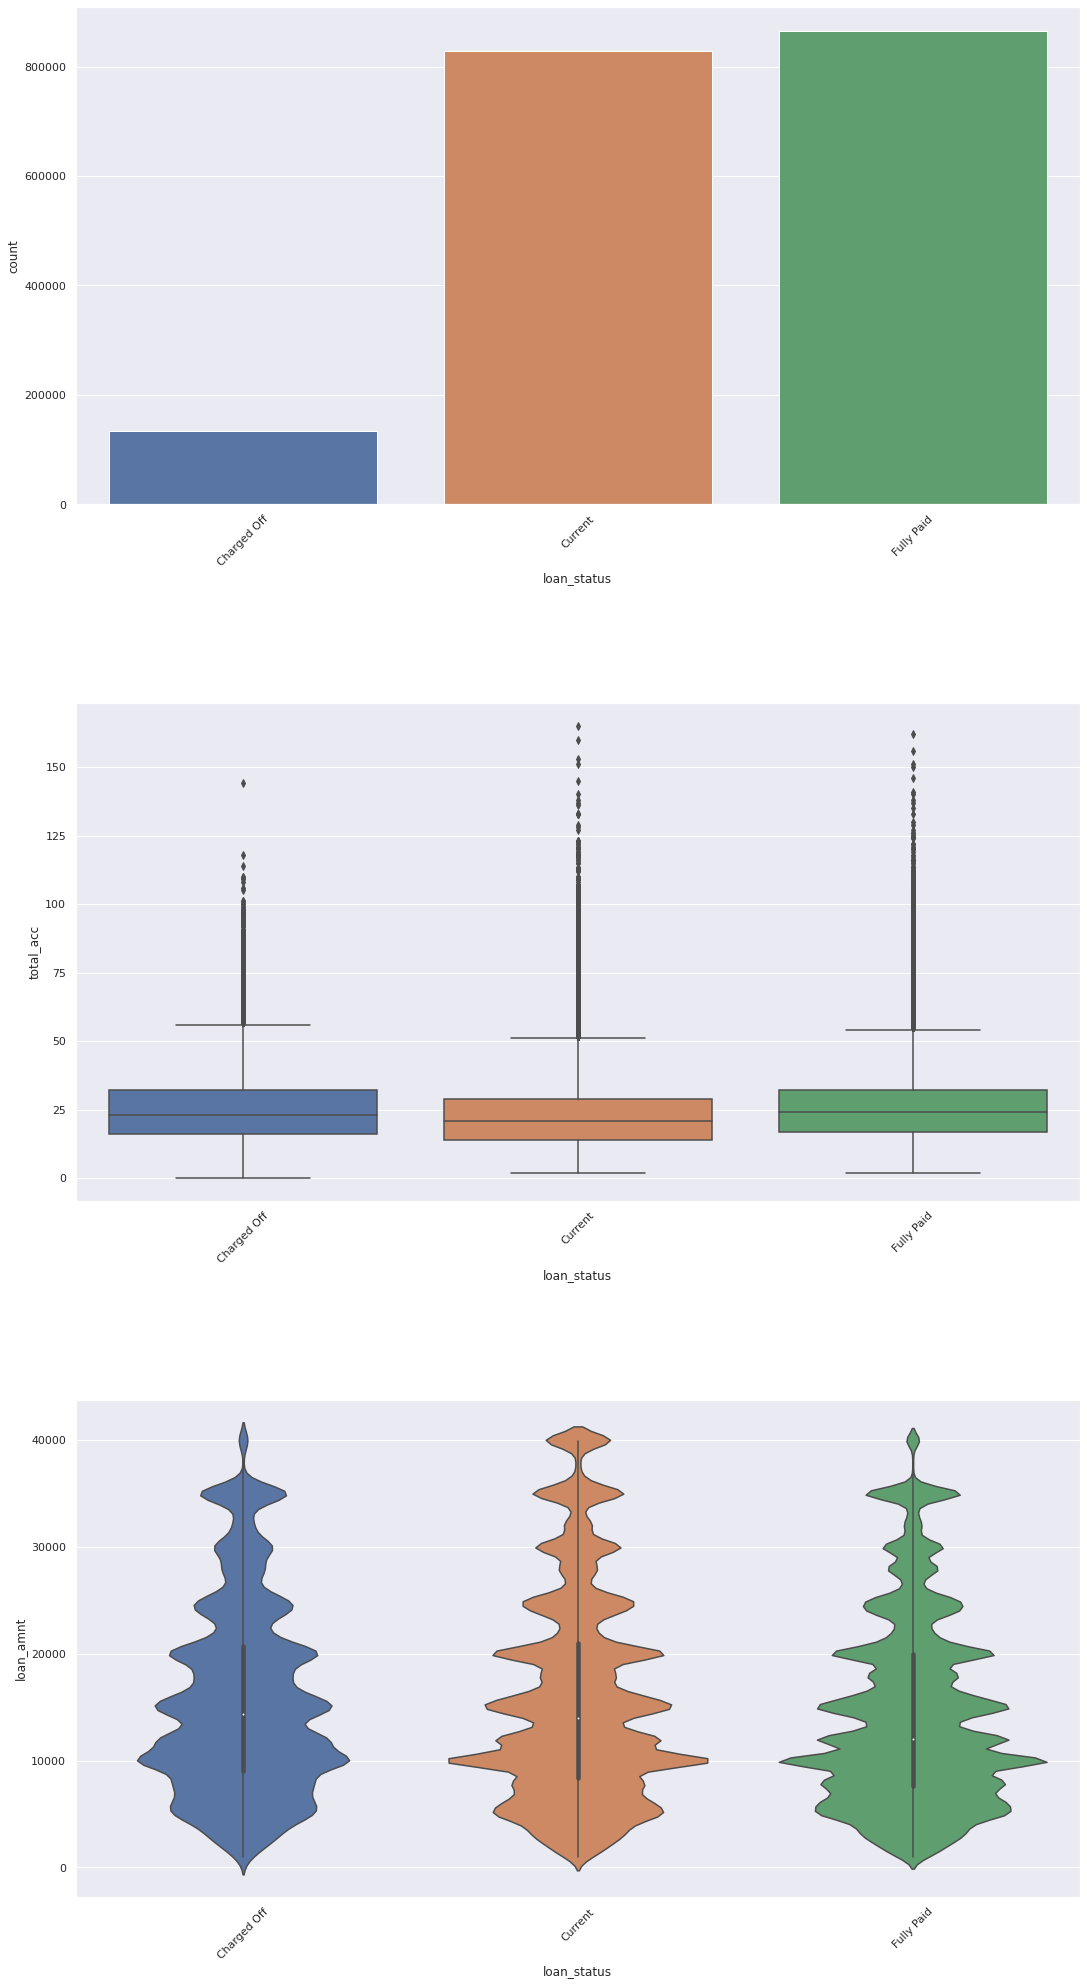

In [ ]:
loanDF = loanDF.withColumn("total_acc",loanDF["total_acc"].cast('float'))

tmp = loanDF.select("loan_status", "total_acc", "loan_amnt").toPandas()

fig, ax =plt.subplots(3,1,figsize=(18,30))
plt.subplots_adjust(hspace = 0.4, top = 1.0)

s0 = sns.countplot(x="loan_status", data=tmp,ax=ax[0])
s0.set_xticklabels(s0.get_xticklabels(),rotation=45)

s1 = sns.boxplot(x="loan_status", y="total_acc", data=tmp,ax=ax[1])
s1.set_xticklabels(s1.get_xticklabels(),rotation=45)

# loan Amount over loan status 
#totalloansOverStatus = pd.DataFrame(loanDF.groupby(loanDF.loan_status)['loan_amnt'].sum())
#totalloansOverStatus = loanDF.groupBy('loan_status').sum('loan_amnt').toPandas()
#totalloansOverStatus.columns = ["Total Loan Amount"]
#totalloansOverStatus.index.names = ["Loan Status"]

s2 = sns.violinplot(x="loan_status", y="loan_amnt", data=tmp,ax=ax[2] , estimator=sum)
#s2 = sns.violinplot(x=totalloansOverStatus.index, y=totalloansOverStatus["Total Loan Amount"],ax=ax[2] )
s2.set_xticklabels(s2.get_xticklabels(),rotation=45)

plt.show()

fig.savefig("/content/drive/My Drive/LoanOveroanStatus.pdf")

## 3. Analysing loan amount distribution for each grade, factored over sub grade.

This shows a linear relationship between loan amount and customer credit ratings, Notice here that requested loan amount is slightly higher for the low rating customers.

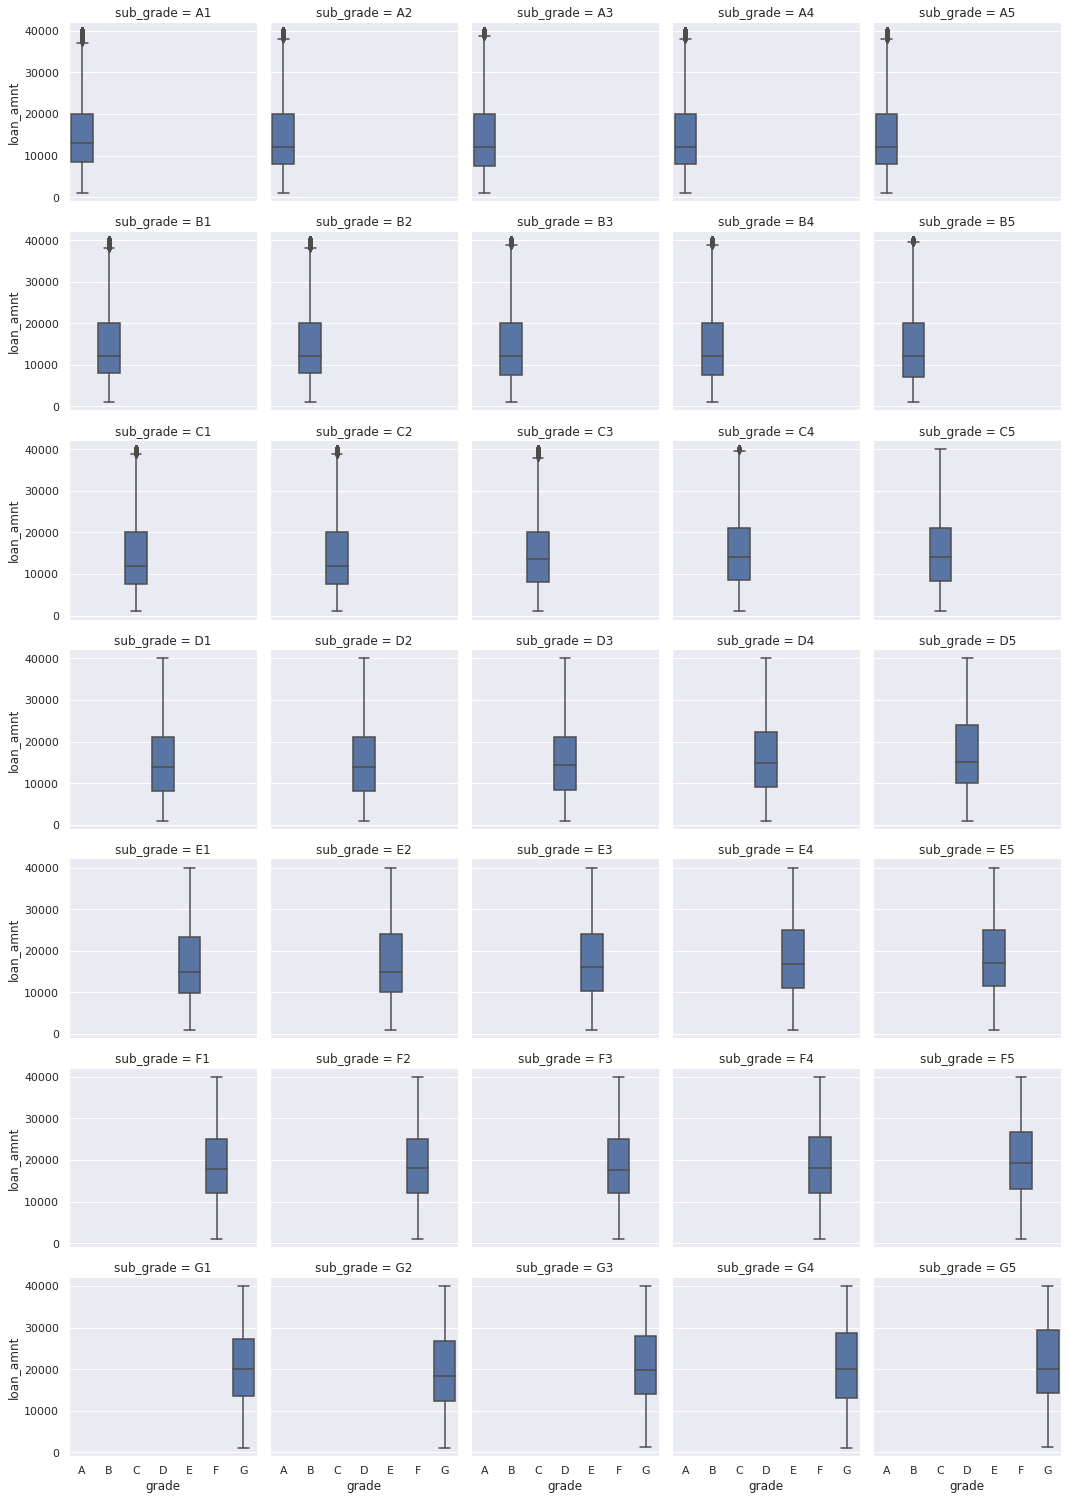

In [ ]:
#sns.boxplot(x="grade", y="loan_amnt", data=loanDF)
tmpDF = loanDF.select("sub_grade", "grade", "loan_amnt", "int_rate").toPandas()
tmpDF['grade'] = tmpDF['grade'].astype('category')
tmpDF['sub_grade'] = tmpDF['sub_grade'].astype('category')
#tmpDF['loan_amnt'] = tmpDF['loan_amnt'].astype('float')
#tmpDF['int_rate'] = tmpDF['int_rate'].astype('float')
#loanDF_Pandas['grade'] = loanDF_Pandas['grade'].astype('category')
#loanDF_Pandas['sub_grade'] = loanDF_Pandas['sub_grade'].astype('category')

#print(tmpDF)

g = sns.FacetGrid(tmpDF, col="sub_grade", sharex=True, col_wrap=5)
#g = sns.FacetGrid(loanDF.toPandas(), col="sub_grade", sharex=False, col_wrap=5)
g.map(sns.boxplot, 'grade', 'loan_amnt')

g.savefig("/content/drive/My Drive/FacetGrid_LoanAmt.pdf")
#fig.savefig("FacetGrid_LoanAmt.pdf")

## 4. Analyzing interest rate distribution for each grade, factored over sub grade.

This shows the interest rates goes high for low credit rating customers. 

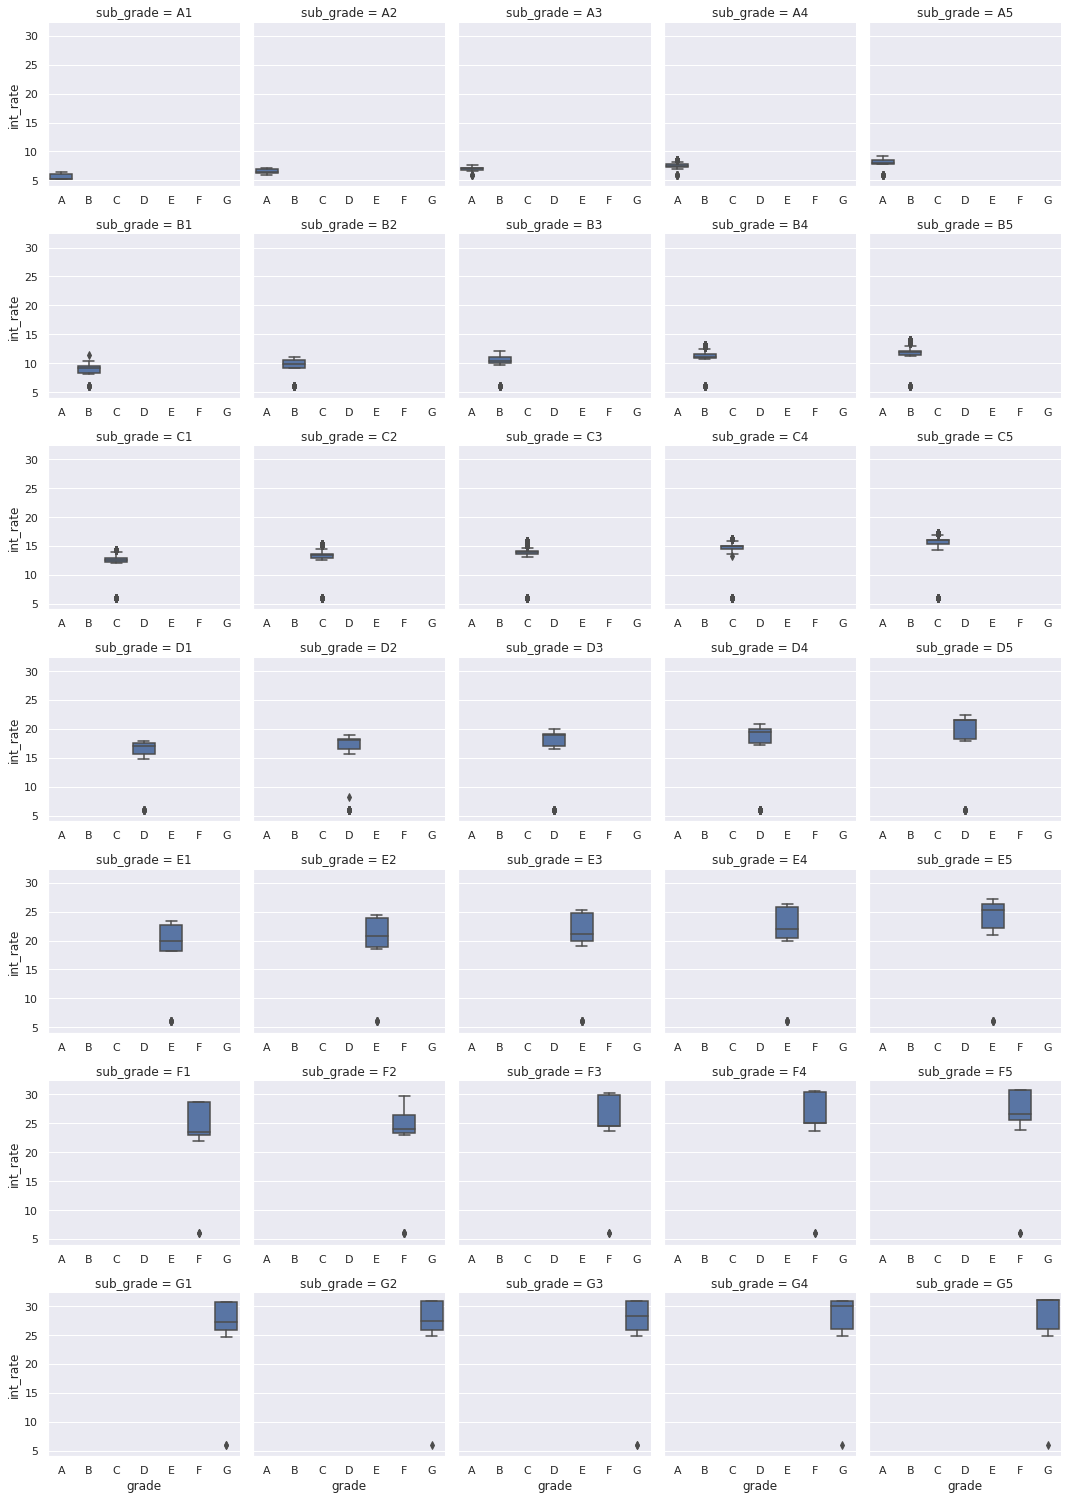

In [ ]:
g = sns.FacetGrid(tmpDF, col="sub_grade", sharex=False, col_wrap=5)
#g = sns.FacetGrid(loanDF.toPandas(), col="sub_grade", sharex=False, col_wrap=5)
g.map(sns.boxplot, 'grade', 'int_rate')

g.savefig("/content/drive/My Drive/FacetGrid_LoanInt.pdf")
#figure.savefig("FacetGrid_LoanInt.pdf")

# Part 2: Data Cleaning & Missing Data Imputation

In [ ]:
# find list of columns which has more than 50% of data missing.
loanDFRows = loanDF.count()
def findMissingValueCols(df):
    df.select([count(when(isnan(c) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()
    missingValueColumns = []
    for column in df.columns:
        nullRows = df.where(col(column).isNull()).count()
        nullRowsPercent = nullRows /loanDFRows
        if nullRows > loanDFRows*0.5 : # i.e. if ALL values are NULL
            missingValueColumns.append(column)
            print(column, "--", nullRowsPercent)
    return missingValueColumns

# columns names which has more than 50% data missing
missingValueColList = findMissingValueCols(loanDF)

print(missingValueColList)

+-------+---------+---------+-----------+---------------+----+--------+-----------+-----+---------+---------+----------+--------------+----------+-------------------+-------+-----------+----------+-------+-------+-------+-----+--------+----------+----+-----------+----------------+--------------+----------------------+----------------------+--------+-------+---------+----------+---------+-------------------+---------+-------------+-----------+---------------+---------------+-------------+------------------+----------+-----------------------+------------+---------------+------------+------------------+--------------------------+---------------------------+-----------+----------------+----------------+---------+-------------------------+--------------+------------+-----------+-----------+-----------+-----------+-----------+------------------+------------+-------+-----------+-----------+----------+--------+----------------+------+-----------+------------+--------------------+-----------+--

In [ ]:
print(len(missingValueColList))

44


In [ ]:
loanDFForModel = loanDFForModel.withColumn("isDefault", when(col("loan_status").isin("Charged Off", 1).otherwise(0))

In [ ]:
# Cleaning up the data

######### 1. Removing all the features which has more than 50% of the data empty ##########
# Temporary setting these hard coded values. (Above section takes lot of time to run)
missingValueColList = ['id', 'member_id', 'url', 'desc', 'mths_since_last_delinq', 'mths_since_last_record', 'next_pymnt_d', 'mths_since_last_major_derog', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'mths_since_recent_bc_dlq', 'mths_since_recent_revol_delinq', 'revol_bal_joint', 'sec_app_earliest_cr_line', 'sec_app_inq_last_6mths', 'sec_app_mort_acc', 'sec_app_open_acc', 'sec_app_revol_util', 'sec_app_open_act_il', 'sec_app_num_rev_accts', 'sec_app_chargeoff_within_12_mths', 'sec_app_collections_12_mths_ex_med', 'sec_app_mths_since_last_major_derog', 'hardship_type', 'hardship_reason', 'hardship_status', 'deferral_term', 'hardship_amount', 'hardship_start_date', 'hardship_end_date', 'payment_plan_start_date', 'hardship_length', 'hardship_dpd', 'hardship_loan_status', 'orig_projected_additional_accrued_interest', 'hardship_payoff_balance_amount', 'hardship_last_payment_amount', 'debt_settlement_flag_date', 'settlement_status', 'settlement_date', 'settlement_amount', 'settlement_percentage', 'settlement_term']
loanDFForModel = loanDF.drop(*missingValueColList)

######### 2. Removing unique ID columns ##########
# Dropping date columns (Don't help much in data analysis/modelling)
loanDFForModel = loanDFForModel.drop("issue_d")
# Dropping the columns which were created for data analysis.
#loanDFForModel = loanDFForModel.drop("issue_d_dateType", "issue_year", "annual_inc_range")

######### 3. Removing Other insignificant columns ########## 
# application_type has only INDIVIDUAL, can be removed. 
# pymnt_plan & initial_list_status has only one category "n" & "f". Keeping state feature instead of zip_code.
# removing date fileds as well. policy_code has only one category "1"
loanDFForModel = loanDFForModel.drop("emp_title", "title", "zip_code", "earliest_cr_line", "last_pymnt_d", "last_credit_pull_d", "policy_code" )